In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from scripts import class_scripts

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import dataset
data = pd.read_pickle('../data/data_outputs/feature_engineered/cleaned_dataset.pkl')

In [3]:
data = data.drop(columns = ['source'])

In [4]:
# Splitting train, test and validation sets
X_ = data.drop(columns = ['TARGET']).values
y_ = data['TARGET'].values

X_tr, X_test, y_tr, y_test = train_test_split(X_, y_, test_size = 0.35, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size = 0.2, random_state = 42)

In [5]:
# Proportion of positives in each subset
[y_.mean(), y_train.mean(), y_tr.mean(), y_val.mean(), y_test.mean()]

[0.08072986956394489,
 0.08124925736227588,
 0.08093396504885456,
 0.07967280368220933,
 0.0803508380718772]

# LightGBM model

In [6]:
# LightGBM model
model = lightgbm.LGBMClassifier(objective='binary', 
                                boosting_type = 'goss', 
                                n_estimators = 1000, 
                                class_weight = 'balanced')

# Training
model.fit(X_train, y_train, 
          early_stopping_rounds = 100, 
          eval_set = [(X_val, y_val)],
          eval_metric = 'auc',
          verbose = 200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.776956	valid_0's binary_logloss: 0.4936
Early stopping, best iteration is:
[148]	valid_0's auc: 0.777306	valid_0's binary_logloss: 0.511387


LGBMClassifier(boosting_type='goss', class_weight='balanced', n_estimators=1000,
               objective='binary')

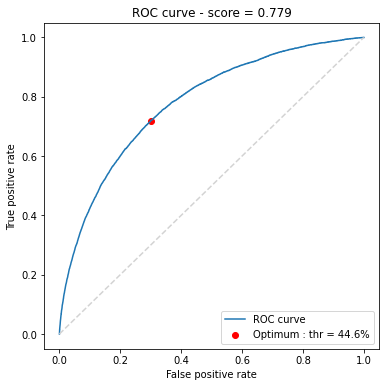

In [7]:
# Prediction and score
y_pred = model.predict_proba(X_test)

plt.figure(figsize = (6,6))
class_scripts.plot_roc(y_test, y_pred[:,1])
plt.show()

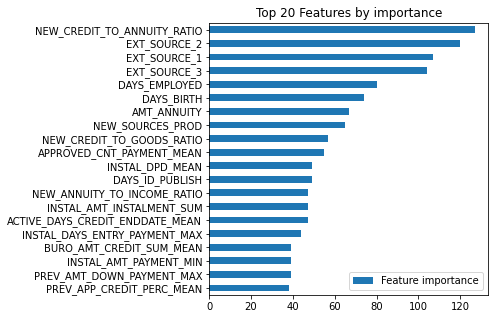

In [8]:
df_fi = pd.DataFrame(model.feature_importances_, index = data.drop(columns = ['TARGET']).columns)
df_fi.sort_values(0).tail(20).plot(kind = 'barh', figsize = (5,5))
plt.legend(['Feature importance'])
plt.title('Top 20 Features by importance')
plt.show()

# LightGBM model with cross validation